In [1]:
import numpy as np
import pandas as pd
import requests
import json
#from scipy import stats as st

In [2]:
tiles = pd.read_csv(r'.\Data\Tiles_expanded.csv')

In [7]:
tiles.head(5)

,Unnamed: 0.1,Unnamed: 0,Tile_ID,Lat1,Lat2,Long1,Long2,Mid_lat,Mid_long,Stop_Signs,Paving,Future,Historical
0,0,0,0,37.708251,37.709155,-122.391313,-122.392454,37.708703,-122.391884,0.0,0.0,0.0,0.0
1,1,1,1,37.708251,37.709155,-122.392454,-122.393594,37.708703,-122.393024,3.0,0.0,0.0,0.0
2,2,2,2,37.708251,37.709155,-122.393594,-122.394734,37.708703,-122.394164,1.0,0.0,0.0,0.0
3,3,3,3,37.708251,37.709155,-122.394734,-122.395874,37.708703,-122.395304,0.0,0.0,0.0,0.0
4,4,4,4,37.708251,37.709155,-122.395874,-122.397014,37.708703,-122.396444,0.0,0.0,0.0,0.0


Split into training and test

In [3]:
from sklearn.model_selection import train_test_split
import scipy

x_train, x_test, y_train, y_test = train_test_split(tiles[['Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving']], 
                                   tiles['Future'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Train model

In [13]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# x: lat, long, historical
# y: future 

def create_linear_model():

    input = tf.keras.layers.Input(shape=(5,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

   # normalized = layers.Normalization(input_shape=[5,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error' #,
        #metrics = [tf.keras.metrics.Accuracy()]
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(x_train).astype('float32'),
    y_train,
    epochs=20,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
245/245 [==============================] - 2s 5ms/step - loss: 61.3525 - val_loss: 41.3083
Epoch 2/20
245/245 [==============================] - 1s 4ms/step - loss: 21.5459 - val_loss: 2.9421
Epoch 3/20
245/245 [==============================] - 1s 3ms/step - loss: 1.4974 - val_loss: 1.3136
Epoch 4/20
245/245 [==============================] - 1s 3ms/step - loss: 1.1562 - val_loss: 1.0517
Epoch 5/20
245/245 [==============================] -

In [15]:
import matplotlib
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

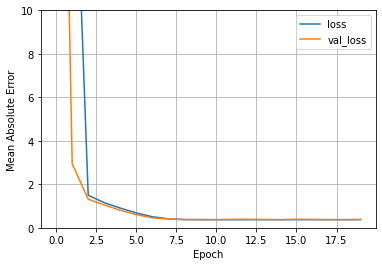

In [16]:
plot_loss(history)

Test model

Model actual future collisions

Create dashboard featuring future hotspots